
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/059_Model_Quantization_INT8.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/59_Model_Quantization_INT8.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 📉 Kwantyzacja (Quantization): Jak zmieścić słonia w pudełku?

Wielkie modele (LLM) ważą setki gigabajtów. Żeby je uruchomić na telefonie, musimy je skompresować.
Najpopularniejszą metodą jest **Post-Training Quantization (PTQ)** z FP32 do INT8.

**Matematyka:**
Musimy zmapować zakres liczb rzeczywistych $[min, max]$ na zakres liczb całkowitych $[-128, 127]$ (lub $[0, 255]$).

Wzór:
$$ Q = \text{round}\left(\frac{R}{S} + Z\right) $$
$$ R = (Q - Z) \cdot S $$

*   $R$: Real value (liczba oryginalna, np. 0.53).
*   $Q$: Quantized value (liczba całkowita, np. 42).
*   $S$: **Scale** (krok, szerokość schodka).
*   $Z$: **Zero Point** (gdzie na osi liczb całkowitych leży prawdziwe zero?).

Zaimplementujemy ten mechanizm od zera.

Oryginał (FP32):
Min: -1.3899
Max: 1.5227
Pamięć: 4000 bajtów


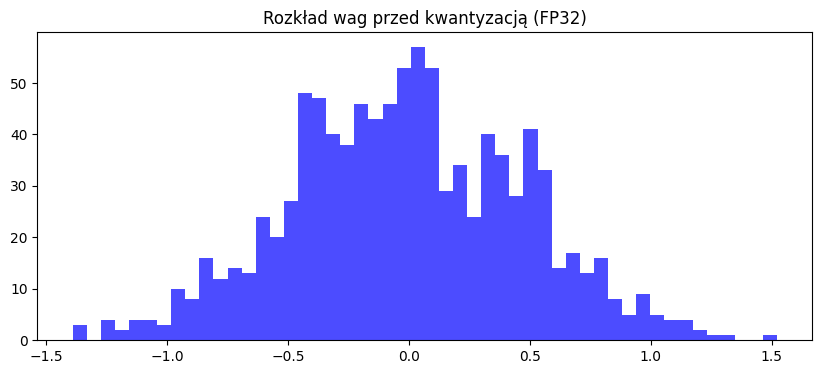

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. TWORZYMY WAGI (Symulacja warstwy sieci)
# Wagi w sieciach to zazwyczaj małe liczby wokół zera (rozkład normalny)
original_weights = torch.randn(1000) * 0.5  # FP32 (32-bit float)

print(f"Oryginał (FP32):")
print(f"Min: {original_weights.min():.4f}")
print(f"Max: {original_weights.max():.4f}")
print(f"Pamięć: {original_weights.element_size() * original_weights.nelement()} bajtów")

# Wizualizacja
plt.figure(figsize=(10, 4))
plt.hist(original_weights.numpy(), bins=50, color='blue', alpha=0.7)
plt.title("Rozkład wag przed kwantyzacją (FP32)")
plt.show()

## Obliczanie Parametrów (Kalibracja)

Musimy znaleźć $S$ (Scale) i $Z$ (Zero Point).
Chcemy zmieścić zakres $[min_{val}, max_{val}]$ w zakresie $[0, 255]$ (uint8).

1.  **Scale:** Cały zakres danych dzielimy przez liczbę dostępnych wiaderek (255).
    $$ S = \frac{max_{val} - min_{val}}{255} $$
2.  **Zero Point:** Musimy wiedzieć, która liczba całkowita odpowiada rzeczywistemu `0.0`.
    $$ Z = \text{round}\left(0 - \frac{min_{val}}{S}\right) $$

In [2]:
# 1. Znajdź zakres
min_val = original_weights.min()
max_val = original_weights.max()

# 2. Definiujemy zakres docelowy (UINT8: 0 do 255)
q_min = 0
q_max = 255

# 3. Oblicz Scale
scale = (max_val - min_val) / (q_max - q_min)

# 4. Oblicz Zero Point
zero_point = q_min - min_val / scale
zero_point = torch.round(zero_point).clamp(q_min, q_max).int() # Musi być int!

print(f"Scale: {scale:.6f}")
print(f"Zero Point: {zero_point.item()}")

Scale: 0.011422
Zero Point: 122


## Kwantyzacja (Kompresja)

Teraz zamieniamy floaty na inty.
Używamy wzoru: $Q = \text{round}(R / S + Z)$.
Musimy też pamiętać o **clampowaniu** (obcięciu), żeby nie wyjść poza zakres 0-255.

In [3]:
# Funkcja kwantyzująca
def quantize(x, s, z):
    q = torch.round(x / s + z)
    q = q.clamp(0, 255) # Zabezpieczenie
    return q.to(torch.uint8) # Rzutowanie na typ 8-bitowy

# Wykonaj kwantyzację
quantized_weights = quantize(original_weights, scale, zero_point)

print("--- PO KWANTYZACJI (INT8) ---")
print(quantized_weights[:10]) # Pierwsze 10 liczb
print(f"Pamięć: {quantized_weights.element_size() * quantized_weights.nelement()} bajtów")
print("Waga spadła 4-krotnie!")

--- PO KWANTYZACJI (INT8) ---
tensor([132, 107, 198, 105, 113, 219, 186,  51, 156, 206], dtype=torch.uint8)
Pamięć: 1000 bajtów
Waga spadła 4-krotnie!


## Dekwantyzacja (Rozpakowanie) i Błąd

Model nie umie mnożyć INT8 (zazwyczaj). Podczas obliczeń (inference) procesor zamienia te liczby z powrotem na przybliżone FP32.
$$ R' = (Q - Z) \cdot S $$

Sprawdźmy, ile informacji straciliśmy. To się nazywa **Quantization Error**.

Średni błąd rekonstrukcji: 0.002807


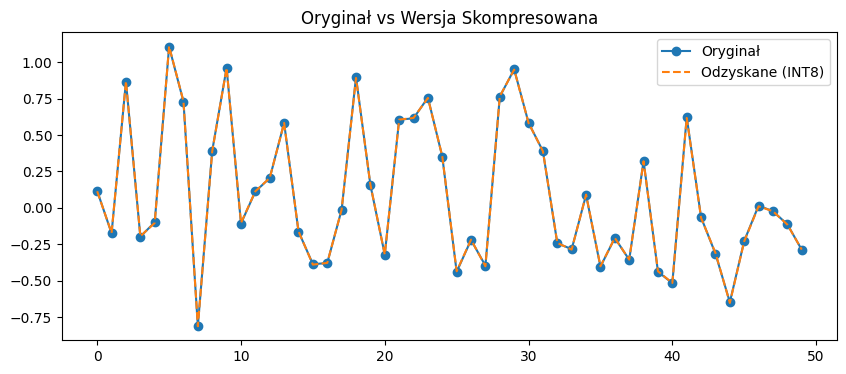

In [4]:
# Funkcja dekwantyzująca
def dequantize(q, s, z):
    return (q.float() - z) * s

# Odzyskujemy wagi
recovered_weights = dequantize(quantized_weights, scale, zero_point)

# Liczymy błąd
error = (original_weights - recovered_weights).abs().mean()

print(f"Średni błąd rekonstrukcji: {error:.6f}")

# Wizualizacja błędu
plt.figure(figsize=(10, 4))
# Rysujemy mały wycinek, żeby zobaczyć różnicę
plt.plot(original_weights[:50].numpy(), label='Oryginał', marker='o')
plt.plot(recovered_weights[:50].numpy(), label='Odzyskane (INT8)', linestyle='--')
plt.title("Oryginał vs Wersja Skompresowana")
plt.legend()
plt.show()

## 🧠 Podsumowanie: Czy warto?

Spójrz na wykres. Linie prawie się pokrywają. Błąd jest na poziomie `0.002`.
Dla sieci neuronowej to **często pomijalna różnica**. Kot nadal wygląda jak kot, a tekst nadal ma sens.

**Zalety Kwantyzacji:**
1.  **Rozmiar:** Model 4x mniejszy (np. Llama 7B spada z 14GB do 3.5GB).
2.  **Prędkość:** Procesory (CPU/GPU) wykonują operacje na liczbach całkowitych (INT8) znacznie szybciej niż na zmiennoprzecinkowych.

**Wady:**
1.  Traci się precyzję (delikatny spadek Accuracy).
2.  Przy bardzo agresywnej kwantyzacji (np. do 4-bitów, GPTQ) model może zgłupieć ("Brain Damage").